# GAN-BERT

This is adapted from the open source implementation available at https://github.com/crux82/ganbert

In [ ]:
!pip install transformers==4.3.2
import torch
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install sentencepiece

##Set random values
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


### Input Parameters


In [ ]:
#--------------------------------
#  Transformer parameters
#--------------------------------
max_seq_length = 64
batch_size = 64

#--------------------------------
#  GAN-BERT specific parameters
#--------------------------------
# number of hidden layers in the generator, 
# each of the size of the output space
num_hidden_layers_g = 1; 
# number of hidden layers in the discriminator, 
# each of the size of the input space
num_hidden_layers_d = 1; 
# size of the generator's input noisy vectors
noise_size = 100
# dropout to be applied to discriminator's input vectors
out_dropout_rate = 0.2

# Replicate labeled data to balance poorly represented datasets, 
# e.g., less than 1% of labeled material
apply_balance = True

#--------------------------------
#  Optimization parameters
#--------------------------------
learning_rate_discriminator = 5e-5
learning_rate_generator = 5e-5
epsilon = 1e-8
num_train_epochs = 10
multi_gpu = True
# Scheduler
apply_scheduler = False
warmup_proportion = 0.1
# Print
print_each_n_step = 10

#--------------------------------
#  Adopted Tranformer model
#--------------------------------
# Since this version is compatible with Huggingface transformers, you can uncomment
# (or add) transformer models compatible with GAN

model_name = "bert-base-cased"
#model_name = "bert-base-uncased"
#model_name = "roberta-base"
#model_name = "albert-base-v2"
#model_name = "xlm-roberta-base"
#model_name = "amazon/bort"

#--------------------------------
#  Retrieve the TREC QC Dataset
#--------------------------------
! git clone https://github.com/crux82/ganbert

#  NOTE: in this setting 50 classes are involved
labeled_file = "./ganbert/data/labeled.tsv"
unlabeled_file = "./ganbert/data/unlabeled.tsv"
test_filename = "./ganbert/data/test.tsv"

label_list = ["UNK_UNK","ABBR_abb", "ABBR_exp", "DESC_def", "DESC_desc", 
              "DESC_manner", "DESC_reason", "ENTY_animal", "ENTY_body", 
              "ENTY_color", "ENTY_cremat", "ENTY_currency", "ENTY_dismed", 
              "ENTY_event", "ENTY_food", "ENTY_instru", "ENTY_lang", 
              "ENTY_letter", "ENTY_other", "ENTY_plant", "ENTY_product", 
              "ENTY_religion", "ENTY_sport", "ENTY_substance", "ENTY_symbol", 
              "ENTY_techmeth", "ENTY_termeq", "ENTY_veh", "ENTY_word", "HUM_desc", 
              "HUM_gr", "HUM_ind", "HUM_title", "LOC_city", "LOC_country", 
              "LOC_mount", "LOC_other", "LOC_state", "NUM_code", "NUM_count", 
              "NUM_date", "NUM_dist", "NUM_money", "NUM_ord", "NUM_other", 
              "NUM_perc", "NUM_period", "NUM_speed", "NUM_temp", "NUM_volsize", 
              "NUM_weight"]

fatal: destination path 'ganbert' already exists and is not an empty directory.


Load the Tranformer Model

In [ ]:
transformer = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Function required to load the dataset

In [ ]:
def get_qc_examples(input_file):
  """Creates examples for the training and dev sets."""
  examples = []

  with open(input_file, 'r') as f:
      contents = f.read()
      file_as_list = contents.splitlines()
      for line in file_as_list[1:]:
          split = line.split(" ")
          question = ' '.join(split[1:])

          text_a = question
          inn_split = split[0].split(":")
          label = inn_split[0] + "_" + inn_split[1]
          examples.append((text_a, label))
      f.close()

  return examples

**Load** the input QC dataset (fine-grained)

In [ ]:
#Load the examples
labeled_examples = get_qc_examples(labeled_file)
unlabeled_examples = get_qc_examples(unlabeled_file)
test_examples = get_qc_examples(test_filename)

Functions required to convert examples into Dataloader

In [ ]:
def generate_data_loader(input_examples, label_masks, label_map, do_shuffle = False, balance_label_examples = False):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  examples = []

  # Count the percentage of labeled examples  
  num_labeled_examples = 0
  for label_mask in label_masks:
    if label_mask: 
      num_labeled_examples += 1
  label_mask_rate = num_labeled_examples/len(input_examples)

  # if required it applies the balance
  for index, ex in enumerate(input_examples): 
    if label_mask_rate == 1 or not balance_label_examples:
      examples.append((ex, label_masks[index]))
    else:
      # IT SIMULATE A LABELED EXAMPLE
      if label_masks[index]:
        balance = int(1/label_mask_rate)
        balance = int(math.log(balance,2))
        if balance < 1:
          balance = 1
        for b in range(0, int(balance)):
          examples.append((ex, label_masks[index]))
      else:
        examples.append((ex, label_masks[index]))
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []
  label_mask_array = []
  label_id_array = []

  # Tokenization 
  for (text, label_mask) in examples:
    encoded_sent = tokenizer.encode(text[0], add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
    label_id_array.append(label_map[text[1]])
    label_mask_array.append(label_mask)
  
  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]                          
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)
  label_mask_array = torch.tensor(label_mask_array)

  # Building the TensorDataset
  dataset = TensorDataset(input_ids, input_mask_array, label_id_array, label_mask_array)

  if do_shuffle:
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
              dataset,  # The training samples.
              sampler = sampler(dataset), 
              batch_size = batch_size) # Trains with this batch size.

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Convert the input examples into DataLoader

In [ ]:
label_map = {}
for (i, label) in enumerate(label_list):
  label_map[label] = i
#------------------------------
#   Load the train dataset
#------------------------------
train_examples = labeled_examples
#The labeled (train) dataset is assigned with a mask set to True
train_label_masks = np.ones(len(labeled_examples), dtype=bool)
#If unlabel examples are available
if unlabeled_examples:
  train_examples = train_examples + unlabeled_examples
  #The unlabeled (train) dataset is assigned with a mask set to False
  tmp_masks = np.zeros(len(unlabeled_examples), dtype=bool)
  train_label_masks = np.concatenate([train_label_masks,tmp_masks])

train_dataloader = generate_data_loader(train_examples, train_label_masks, label_map, do_shuffle = True, balance_label_examples = apply_balance)

#------------------------------
#   Load the test dataset
#------------------------------
#The labeled (test) dataset is assigned with a mask set to True
test_label_masks = np.ones(len(test_examples), dtype=bool)

test_dataloader = generate_data_loader(test_examples, test_label_masks, label_map, do_shuffle = False, balance_label_examples = False)

In [ ]:
#------------------------------
#   The Generator as in 
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Generator(nn.Module):
    def __init__(self, noise_size=100, output_size=512, hidden_sizes=[512], dropout_rate=0.1):
        super(Generator, self).__init__()
        layers = []
        hidden_sizes = [noise_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        layers.append(nn.Linear(hidden_sizes[-1],output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, noise):
        output_rep = self.layers(noise)
        return output_rep

#------------------------------
#   The Discriminator
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

In [ ]:
# The config file is required to get the dimension of the vector produced by 
# the underlying transformer
config = AutoConfig.from_pretrained(model_name)
hidden_size = int(config.hidden_size)
# Define the number and width of hidden layers
hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]

#-------------------------------------------------
#   Instantiate the Generator and Discriminator
#-------------------------------------------------
generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=hidden_levels_g, dropout_rate=out_dropout_rate)
discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels_d, num_labels=len(label_list), dropout_rate=out_dropout_rate)

# Put everything in the GPU if available
if torch.cuda.is_available():    
  generator.cuda()
  discriminator.cuda()
  transformer.cuda()
  if multi_gpu:
    transformer = torch.nn.DataParallel(transformer)

print(config)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.3.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}



In [ ]:
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

#models parameters
transformer_vars = [i for i in transformer.parameters()]
d_vars = transformer_vars + [v for v in discriminator.parameters()]
g_vars = [v for v in generator.parameters()]

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator) 

#scheduler
if apply_scheduler:
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
  scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
                                           num_warmup_steps = num_warmup_steps)

# For each epoch...
for epoch_i in range(0, num_train_epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    tr_g_loss = 0
    tr_d_loss = 0

    # Put the model into training mode.
    transformer.train() 
    generator.train()
    discriminator.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every print_each_n_step batches.
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_label_mask = batch[3].to(device)
     
        # Encode real data in the Transformer
        model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
        hidden_states = model_outputs[-1]
        
        # Generate fake data that should have the same distribution of the ones
        # encoded by the transformer. 
        # First noisy input are used in input to the Generator
        noise = torch.zeros(b_input_ids.shape[0],noise_size, device=device).uniform_(0, 1)
        # Gnerate Fake data
        gen_rep = generator(noise)

        # Generate the output of the Discriminator for real and fake data.
        # First, we put together the output of the tranformer and the generator
        disciminator_input = torch.cat([hidden_states, gen_rep], dim=0)
        # Then, we select the output of the disciminator
        features, logits, probs = discriminator(disciminator_input)

        # Finally, we separate the discriminator's output for the real and fake
        # data
        features_list = torch.split(features, batch_size)
        D_real_features = features_list[0]
        D_fake_features = features_list[1]
      
        logits_list = torch.split(logits, batch_size)
        D_real_logits = logits_list[0]
        D_fake_logits = logits_list[1]
        
        probs_list = torch.split(probs, batch_size)
        D_real_probs = probs_list[0]
        D_fake_probs = probs_list[1]

        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
        g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
        g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
        g_loss = g_loss_d + g_feat_reg
  
        # Disciminator's LOSS estimation
        logits = D_real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(b_labels, len(label_list))
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
        labeled_example_count = per_example_loss.type(torch.float32).numel()

        # It may be the case that a batch does not contain labeled examples, 
        # so the "supervised loss" in this case is not evaluated
        if labeled_example_count == 0:
          D_L_Supervised = 0
        else:
          D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
                 
        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
        D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        # Avoid gradient accumulation
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()

        # Calculate weigth updates
        # retain_graph=True is required since the underlying graph will be deleted after backward
        g_loss.backward(retain_graph=True)
        d_loss.backward() 
        
        # Apply modifications
        gen_optimizer.step()
        dis_optimizer.step()

        # A detail log of the individual losses
        #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
        #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
        #             g_loss_d, g_feat_reg))

        # Save the losses to print them later
        tr_g_loss += g_loss.item()
        tr_d_loss += d_loss.item()

        # Update the learning rate with the scheduler
        if apply_scheduler:
          scheduler_d.step()
          scheduler_g.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss_g = tr_g_loss / len(train_dataloader)
    avg_train_loss_d = tr_d_loss / len(train_dataloader)             
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss generator: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    transformer.eval() #maybe redundant
    discriminator.eval()
    generator.eval()

    # Tracking variables 
    total_test_accuracy = 0
   
    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

    # Evaluate data for one epoch
    for batch in test_dataloader:
        
        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            hidden_states = model_outputs[-1]
            _, logits, probs = discriminator(hidden_states)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            # Accumulate the test loss.
            total_test_loss += nll_loss(filtered_logits, b_labels)
            
        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()

    # Report the final accuracy for this validation run.
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss = avg_test_loss.item()
    
    # Measure how long the validation run took.
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss generator': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )


======== Epoch 1 / 10 ========
Training...
  Batch    10  of     92.    Elapsed: 0:00:18.
  Batch    20  of     92.    Elapsed: 0:00:36.
  Batch    30  of     92.    Elapsed: 0:00:54.
  Batch    40  of     92.    Elapsed: 0:01:12.
  Batch    50  of     92.    Elapsed: 0:01:29.
  Batch    60  of     92.    Elapsed: 0:01:47.
  Batch    70  of     92.    Elapsed: 0:02:05.
  Batch    80  of     92.    Elapsed: 0:02:23.
  Batch    90  of     92.    Elapsed: 0:02:41.

  Average training loss generator: 0.739
  Average training loss discriminator: 2.845
  Training epoch took: 0:02:45

Running Test...
  Accuracy: 0.464
  Test Loss: 2.704
  Test took: 0:00:03

======== Epoch 2 / 10 ========
Training...
  Batch    10  of     92.    Elapsed: 0:00:18.
  Batch    20  of     92.    Elapsed: 0:00:36.
  Batch    30  of     92.    Elapsed: 0:00:54.
  Batch    40  of     92.    Elapsed: 0:01:12.
  Batch    50  of     92.    Elapsed: 0:01:30.
  Batch    60  of     92.    Elapsed: 0:01:48.
  Batch    70 

In [ ]:
for stat in training_stats:
  print(stat)

print("\nTraining complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

{'epoch': 1, 'Training Loss generator': 0.7390733490819517, 'Training Loss discriminator': 2.844949351704639, 'Valid. Loss': 2.7041358947753906, 'Valid. Accur.': 0.464, 'Training Time': '0:02:45', 'Test Time': '0:00:03'}
{'epoch': 2, 'Training Loss generator': 0.7210313049347504, 'Training Loss discriminator': 1.4546030267425205, 'Valid. Loss': 2.6173174381256104, 'Valid. Accur.': 0.452, 'Training Time': '0:02:45', 'Test Time': '0:00:03'}
{'epoch': 3, 'Training Loss generator': 0.7275488862524861, 'Training Loss discriminator': 1.0127850103637446, 'Valid. Loss': 2.5117886066436768, 'Valid. Accur.': 0.556, 'Training Time': '0:02:45', 'Test Time': '0:00:03'}
{'epoch': 4, 'Training Loss generator': 0.7164584080810132, 'Training Loss discriminator': 0.888008572485136, 'Valid. Loss': 2.471228837966919, 'Valid. Accur.': 0.602, 'Training Time': '0:02:45', 'Test Time': '0:00:03'}
{'epoch': 5, 'Training Loss generator': 0.7138760076916736, 'Training Loss discriminator': 0.8079386748697447, 'Val

In [ ]:
# # from google.colab import files
# # torch.save(generator.state_dict(), 'generator.pth')
# # torch.save(discriminator.state_dict(), 'discriminator.pth')
# # # download checkpoint file
# # files.download('generator.pth')
# #For loading back
# state_dict = torch.load('generator.pth')
# generator.load_state_dict(state_dict)
# state_dict = torch.load('discriminator.pth')
# discriminator.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
###Testing for fake data
noice = torch.zeros(1,100,device = device).uniform_(0,1)
gen_rep = generator(noice)

In [ ]:
gen_rep.shape
features,logits,probs = discriminator(gen_rep)

###Comparing with BASE Bert

In [ ]:

class Base_Model(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Base_Model, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1)
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs
base_model = Base_Model(input_size=hidden_size, hidden_sizes=hidden_levels_d, num_labels=len(label_list), dropout_rate=out_dropout_rate)

In [ ]:

base_model

Base_Model(
  (input_dropout): Dropout(p=0.2, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.2, inplace=False)
  )
  (logit): Linear(in_features=768, out_features=52, bias=True)
  (softmax): Softmax(dim=-1)
)

In [ ]:
if torch.cuda.is_available():    
  base_model.cuda()
  if multi_gpu:
    transformer = torch.nn.DataParallel(transformer)

In [ ]:
training_stats_base = []

# Measure the total training time for the whole run.
total_t0 = time.time()

#models parameters
transformer_vars = [i for i in transformer.parameters()]
base_vars = transformer_vars + [v for v in base_model.parameters()]


#optimizer
base_optimizer = torch.optim.AdamW(base_vars, lr=learning_rate_discriminator)

#scheduler
if apply_scheduler:
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler_b = get_constant_schedule_with_warmup(base_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
  

# For each epoch...
for epoch_i in range(0, num_train_epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    tr_b_loss = 0

    # Put the model into training mode.
    transformer.train() 
    base_model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every print_each_n_step batches.
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_label_mask = batch[3].to(device)
     
        # Encode real data in the Transformer
        model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
        hidden_states = model_outputs[-1]
        
        features, logits, probs = base_model(hidden_states)


        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
  
        # Base Model's LOSS estimation
        logits = logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        label2one_hot = torch.nn.functional.one_hot(b_labels, len(label_list))
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
        labeled_example_count = per_example_loss.type(torch.float32).numel()

        # It may be the case that a batch does not contain labeled examples, 
        # so the "supervised loss" in this case is not evaluated
        if labeled_example_count == 0:
          D_L_Supervised = 0
        else:
          D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
                 
        base_loss = D_L_Supervised

        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        # Avoid gradient accumulation
        base_optimizer.zero_grad()

        
        # Apply modifications
        base_optimizer.step()

        # A detail log of the individual losses
        #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
        #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
        #             g_loss_d, g_feat_reg))

        # Save the losses to print them later

        # Update the learning rate with the scheduler
        if apply_scheduler:
          scheduler_b.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss_b = tr_b_loss / len(train_dataloader)
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss generator: {0:.3f}".format(avg_train_loss_b))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    transformer.eval() #maybe redundant
    base_model.eval()

    # Tracking variables 
    total_test_accuracy = 0
   
    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

    # Evaluate data for one epoch
    for batch in test_dataloader:
        
        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            hidden_states = model_outputs[-1]
            _, logits, probs = base_model(hidden_states)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            # Accumulate the test loss.
            total_test_loss += nll_loss(filtered_logits, b_labels)
            
        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()

    # Report the final accuracy for this validation run.
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss = avg_test_loss.item()
    
    # Measure how long the validation run took.
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))

    # Record all statistics from this epoch.
    training_stats_base.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss base': avg_train_loss_b,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )



======== Epoch 1 / 10 ========
Training...
  Batch    10  of     92.    Elapsed: 0:00:04.
  Batch    20  of     92.    Elapsed: 0:00:09.
  Batch    30  of     92.    Elapsed: 0:00:13.
  Batch    40  of     92.    Elapsed: 0:00:17.
  Batch    50  of     92.    Elapsed: 0:00:21.
  Batch    60  of     92.    Elapsed: 0:00:26.
  Batch    70  of     92.    Elapsed: 0:00:30.
  Batch    80  of     92.    Elapsed: 0:00:34.
  Batch    90  of     92.    Elapsed: 0:00:38.

  Average training loss generator: 0.000
  Training epoch took: 0:00:39

Running Test...
  Accuracy: 0.020
  Test Loss: 3.947
  Test took: 0:00:03

======== Epoch 2 / 10 ========
Training...
  Batch    10  of     92.    Elapsed: 0:00:04.
  Batch    20  of     92.    Elapsed: 0:00:08.
  Batch    30  of     92.    Elapsed: 0:00:13.
  Batch    40  of     92.    Elapsed: 0:00:17.
  Batch    50  of     92.    Elapsed: 0:00:21.
  Batch    60  of     92.    Elapsed: 0:00:25.
  Batch    70  of     92.    Elapsed: 0:00:30.
  Batch    8

Plotting fake data

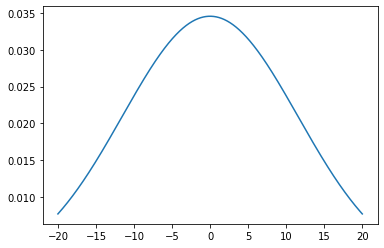

In [ ]:
####Plotting the Fake Data

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
  
# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(-20, 20, 0.01)
  
# Calculating mean and standard deviation
mean = statistics.mean(x_axis)
sd = statistics.stdev(x_axis)
  
plt.plot(x_axis, norm.pdf(x_axis, mean, sd))
plt.show()

In [ ]:
noise_input = []
output_fake_data = []

In [ ]:
s = np.random.normal(0,1, 1000)

In [ ]:
for i in range(1000):
  noice = torch.zeros(1,100,device = device).uniform_(0,1)
  gen_rep = generator(noice)
  noise_input.append(noice)
  output_fake_data.append(gen_rep)

In [ ]:
noise_input = np.array(noise_input)
output_fake_data = np.array(output_fake_data)

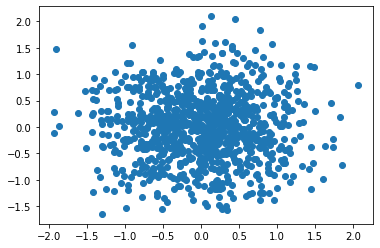

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

M = np.random.rand(944, 1683)
pca = PCA(n_components=2)
reduced = pca.fit_transform(M)

# We need a 2 x 944 array, not 944 by 2 (all X coordinates in one list)
t = reduced.transpose()

plt.scatter(t[0], t[1])
plt.show()
